# SITCOM-1118 Slewing in Azimuth Analysis - Positioning

To analyze the positioning system after a slew in azimuth only

This is very similar to the SITCOM-797_ims_slewing_analysis_positioning notebook, but we select slews where the TMA is moving in azimuth only. The idea is that when the TMA moves in elevation, the IMS is measuring the cell flexure which will be compensated by the hexapods and the Look Up Tables (LUT). By selecting slews where the TMA is movin in azimuth the mirror displacement should remain within the following tolerances:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree (0.0864 arcsec)
* piston less than +/- 1 micrometer

In this version of the notebook we allow a settling times of several seconds (typically 6) before measuring the mirror position and rotation.

# Prepare Notebook

In [156]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [157]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from scipy.stats import linregress

from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [158]:
# Select data from a given period - Here we give a list of dates
# dayObs = [20231118, 20231119, 20231120, 20231121, 20231122, 20231123, 20231124]
# dayObs = [20240109, 20240110]
dayObs = [20240110, 20240111, 20240112]

eventMaker = TMAEventMaker()
for i, d in enumerate(dayObs):
    if i == 0:
        events = eventMaker.getEvents(d)
    else:
        events = events + eventMaker.getEvents(d)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 504 slews


In [159]:
# Create client to access either the idf or the usdf EFD
# client = EfdClient("idf_efd")
client = EfdClient("usdf_efd")

In [160]:
pos_columns = ["xPosition", "yPosition", "zPosition"]
rot_columns = ["xRotation", "yRotation", "zRotation"]
all_columns = pos_columns + rot_columns

# Compute intermediate values that will be used later in the analysis

* Loop over all the slews
* Compute relevant quantities from the EFD
* Store results in a dataframe in order to plot them later
***
For each slew we record the following quantities:
 * **i_slew**: Slew number
 * **duration**: Slew duration
 * **x_mean, y_mean, z_mean**: Average positions
 * **x_sigma, y_sigma, z_sigma**: Sigma on positions
 * **R_x_mean, R_y_mean, R_z_mean**: Average rotations
 * **Rx_sigma, Ry_sigma, Rz_sigma**: Sigma on rotations
 * **dx_max, dy_max, dz_max**: Maximum excursion in position w.r.t. initial position
 * **R_dx_max, R_dy_max, R_dz_max**: Maximum excursion in rotation w.r.t. intitial rotation angle
 * **x_before, y_before, z_before**: Position before slew averaged over a small delta t)
 * **R_x_before, R_y_before, R_z_before**: Rotation angle before slew averaged over a small delta t)
 * **x_after, y_after, z_after**: Position after slew averaged over a small delta t)
 * **R_x_after, R_y_after, R_z_after**: Rotation angle after slew averaged over a small delta t)
 * **start_ele, end_ele**: Elevation angle at the beginning and at the end of the slew
 * **start_azi, end_azi**: Azimuth angle at the beginning and at the end of the slew
 * **speed_ele**: Elevation speed
 * **slew_end**: Timestamp when slew ends

In [161]:
def get_results():
    # define a time window to compute the average mirror position before and after the slews
    # also define a settle time after the slew before checking the mirror position
    settle_t = 6
    delta_t = 2
    dt_begin = time.TimeDelta(-delta_t, format="sec")
    dt_end = time.TimeDelta(delta_t, format="sec")
    dt_settle = time.TimeDelta(settle_t, format="sec")

    # The relevant quantities will be stored in a dataframe
    results = pd.DataFrame(
        columns=[
            "i_slew",
            "duration",
            "x_mean",
            "y_mean",
            "z_mean",
            "x_sigma",
            "y_sigma",
            "z_sigma",
            "R_x_mean",
            "R_y_mean",
            "R_z_mean",
            "Rx_sigma",
            "Ry_sigma",
            "Rz_sigma",
            "dx_max",
            "dy_max",
            "dz_max",
            "R_dx_max",
            "R_dy_max",
            "R_dz_max",
            "x_before",
            "y_before",
            "z_before",
            "R_x_before",
            "R_y_before",
            "R_z_before",
            "x_after",
            "y_after",
            "z_after",
            "R_x_after",
            "R_y_after",
            "R_z_after",
            "start_ele",
            "end_ele",
            "start_azi",
            "end_azi",
            "speed_ele",
            "speed_azi",
            "slew_end",
        ]
    )
    for i_slew, slew in enumerate(slews):
        if slew.blockInfos is None:
            print(f"No blockInfos for slew number {i_slew}")
            continue

        # Get ims data
        df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", event=slew)
        if len(df_ims) == 0:
            print(
                f"No data for slew number: {i_slew} seqNum={slew.seqNum} , begin={slew.begin.datetime64}, end={slew.end.datetime64}"
            )
            continue

        df_ims = df_ims[all_columns]

        # Convert meter to milimeter to make is easier to analyse
        df_ims[pos_columns] = df_ims[pos_columns] * u.m.to(u.mm)

        # get ims data before and after the slew
        df_ims_before = getEfdData(
            client, "lsst.sal.MTM1M3.imsData", begin=slew.begin, timespan=dt_begin
        )
        if len(df_ims_before) == 0:
            print(f"No data before slew number: {i_slew}")
            continue
        df_ims_before = df_ims_before[all_columns]
        df_ims_before[pos_columns] = df_ims_before[pos_columns] * u.m.to(u.mm)

        df_ims_after = getEfdData(
            client,
            "lsst.sal.MTM1M3.imsData",
            begin=slew.end + dt_settle,
            timespan=dt_end,
        )
        if len(df_ims_after) == 0:
            print(f"No data after slew number: {i_slew}")
            continue
        df_ims_after = df_ims_after[all_columns]
        df_ims_after[pos_columns] = df_ims_after[pos_columns] * u.m.to(u.mm)

        # In order to avoid duplicating code for the various positions / rotations we store results in dictionaries
        # with keys equal to xPosition, yPosition, ... xRotation, ...
        mean = {}
        sigma = {}
        max_diff = {}
        mean_before = {}
        mean_after = {}
        for col in all_columns:
            mean[col] = np.mean(df_ims[col])
            sigma[col] = np.std(df_ims[col])
            t0 = df_ims.index[0]
            max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0] - df_ims[col]))

            mean_before[col] = np.mean(df_ims_before[col])
            mean_after[col] = np.mean(df_ims_after[col])

        # get elevation data
        df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
        if len(df_ele) == 0:
            print(f"No elevation data for slew number: {i_slew}")
            continue
        pos_ele = df_ele["actualPosition"]
        start_ele = pos_ele[pos_ele.index[0]]
        end_ele = pos_ele[pos_ele.index[len(pos_ele) - 1]]
        # get speed
        speed_ele = np.mean(df_ele["demandVelocity"])

        # get azimuth data
        df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)
        if len(df_azi) == 0:
            print(f"No azimuth data for slew number: {i_slew}")
            continue
        pos_azi = df_azi["actualPosition"]
        start_azi = pos_azi[pos_azi.index[0]]
        end_azi = pos_azi[pos_azi.index[len(pos_azi) - 1]]
        speed_azi = np.mean(df_azi["demandVelocity"])

        # Store computed values in dataframe
        # Pandas requires the values in each rows to be passed as a flat vector
        # First we need to extract the values from the dictionaries
        vect = [
            [i_slew],
            [slew.duration],
            [mean[i] for i in pos_columns],
            [sigma[i] for i in pos_columns],
            [mean[i] for i in rot_columns],
            [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns],
            [max_diff[i] for i in rot_columns],
            [mean_before[i] for i in pos_columns],
            [mean_before[i] for i in rot_columns],
            [mean_after[i] for i in pos_columns],
            [mean_after[i] for i in rot_columns],
            [start_ele],
            [end_ele],
            [start_azi],
            [end_azi],
            [speed_ele],
            [speed_azi],
            [slew.end],
        ]
        flat_vect = [item for sublist in vect for item in sublist]
        results = pd.concat(
            [results, pd.DataFrame([flat_vect], columns=results.columns)],
            ignore_index=True,
        )
    return results

In [162]:
# As the EFD queries can be very long to execute we offer the possibility to store the results dataframe in a csv file for later use

file_path = "slews_azi.csv"  # Path to file to store result dataframe
if os.path.exists(file_path):
    results = pd.read_csv(file_path)
else:
    results = get_results()
    results.to_csv(file_path)

# The analysis is starting here

We use the results dataframe to create plots

## Histogram of the difference between positions / rotations after and before the slews

**In this first analysis, we compare the positions and rotations given by the IMS at the end of the slews to the one at the start of the slew**

The differences are plotted in histograms


Found 2 outliers xPosition (limit: 100 microns)
Found 8 outliers xRotation (limit: 1 arcsec)
Found 5 outliers yPosition (limit: 100 microns)
Found 5 outliers yRotation (limit: 1 arcsec)
Found 5 outliers zPosition (limit: 100 microns)
Found 5 outliers zRotation (limit: 1 arcsec)


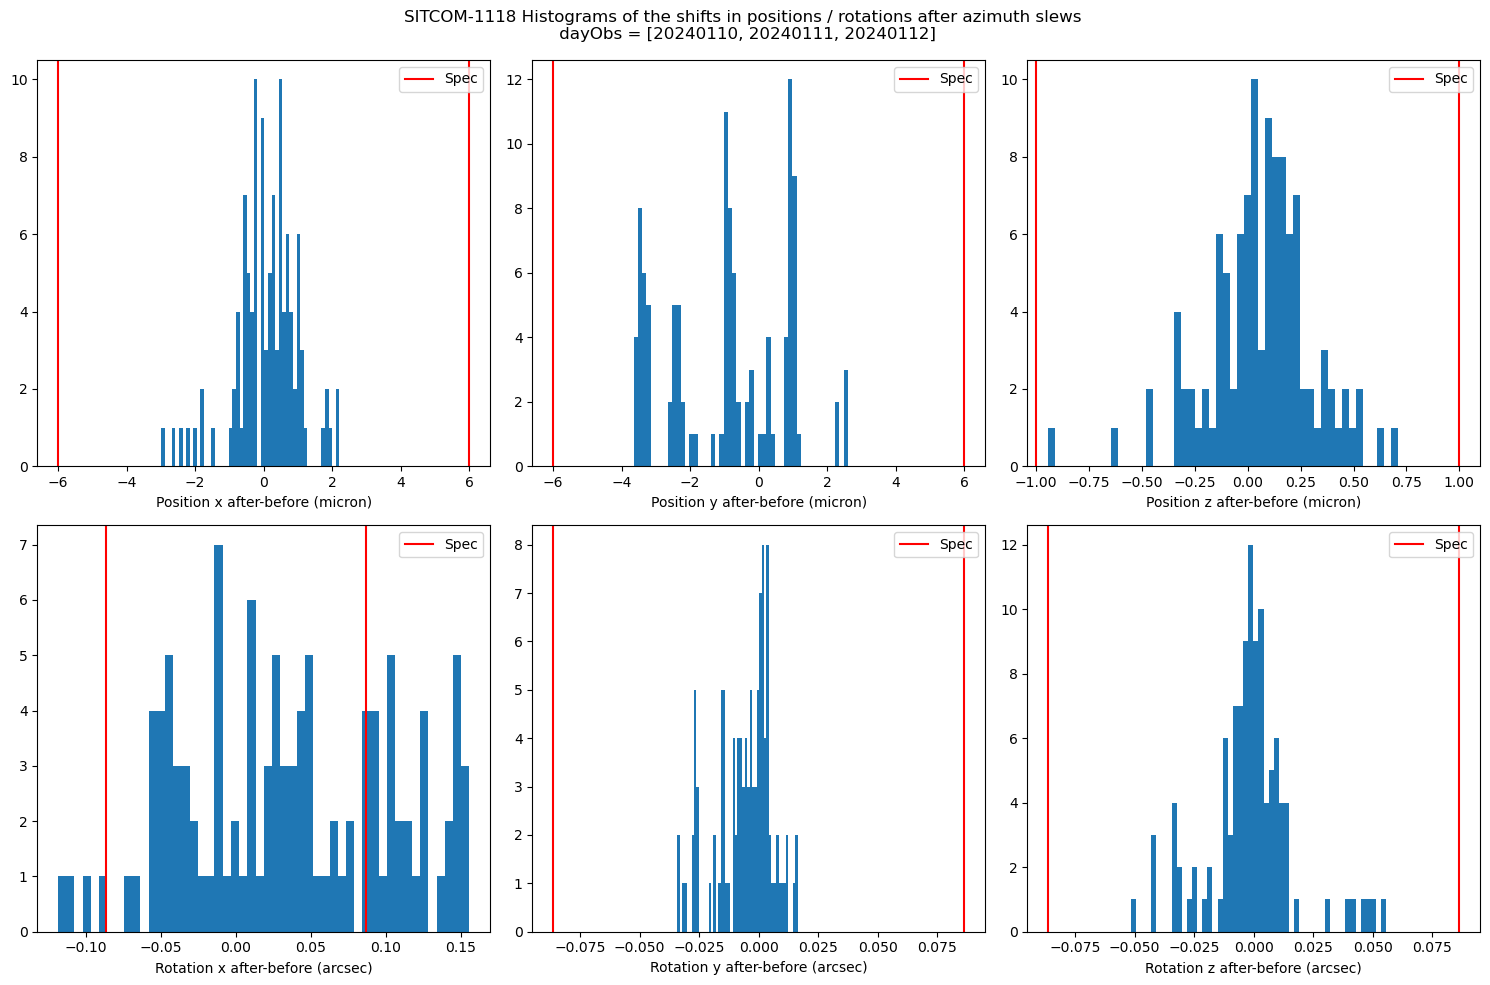

In [163]:
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for outliers
# Note that these outliers would deserve a specific study...
out_limit_pos = 100
out_limit_rot = 1

title = f"SITCOM-1159 Histograms of the shifts in positions / rotations after azimuth slews \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 10))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 0.1
)

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")

    # add lines and labels for tolerances
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color="r", label="Spec")
        axs[0][i].axvline(-6, color="r")
        axs[0][i].legend()

        axs[1][i].axvline(0.0864, color="r", label="Spec")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].legend()

    else:
        axs[0][i].axvline(1, color="r", label="Spec")
        axs[0][i].axvline(-1, color="r")
        axs[0][i].legend()

        axs[1][i].axvline(0.0864, color="r", label="Spec")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

## Conclusion

Using slews in azimuth only and the latest data acquired in January we observe that all the displacements / rotation are within the specifications 
but for the rotation around the x axis where some values are out of the targeted window

## Check whether the mirror displacement is correlated to the azimuth difference ( end of slew - start of slew)


Number of azimuth only slews taken into account in the analysis: 111

Found 2 outliers for xPosition (limit: 100 microns)
Found 8 outliers for xRotation (limit: 1 arcsec)
Found 5 outliers for yPosition (limit: 100 microns)
Found 5 outliers for yRotation (limit: 1 arcsec)
Found 5 outliers for zPosition (limit: 100 microns)
Found 5 outliers for zRotation (limit: 1 arcsec)


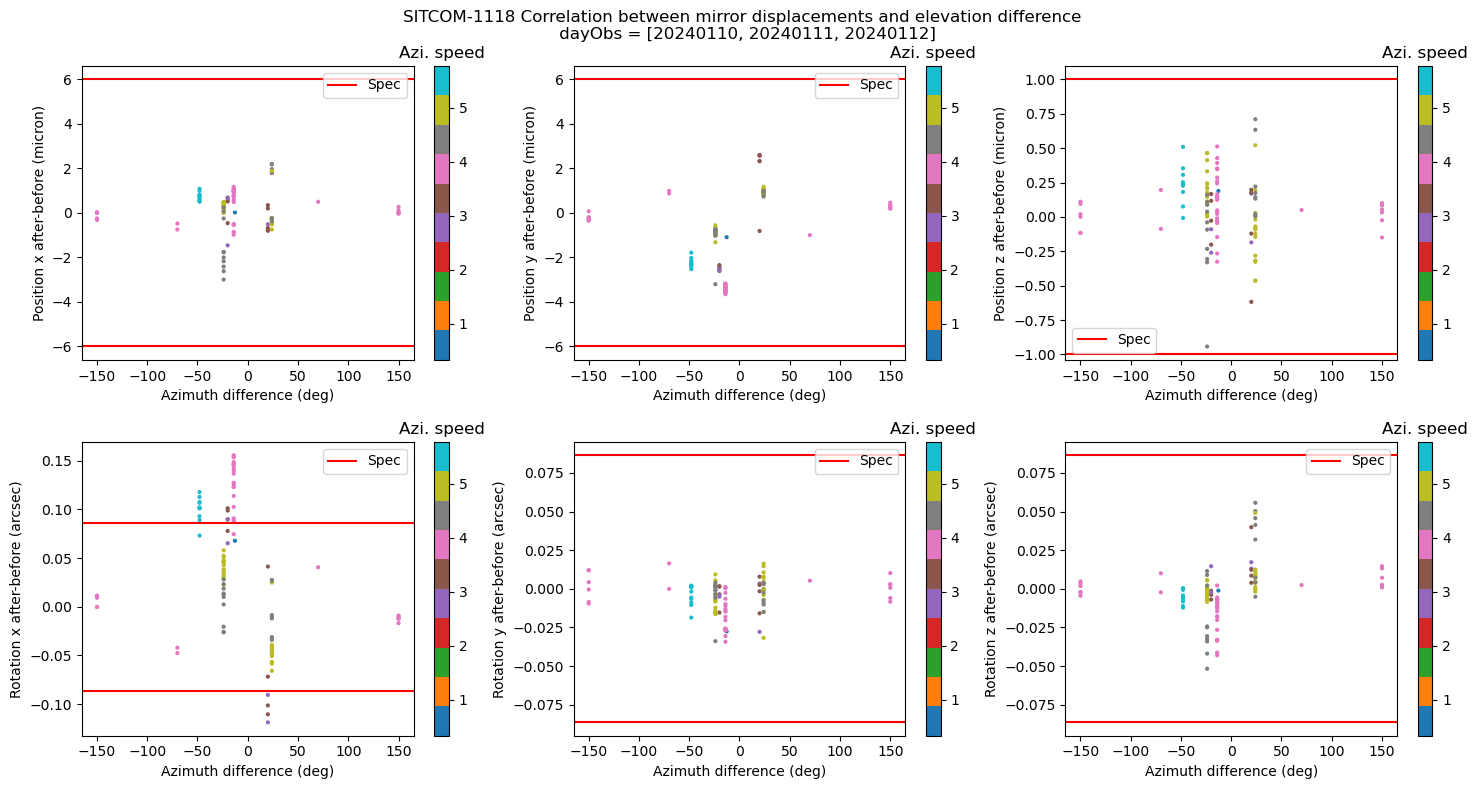

In [164]:
# The color scale represents the slew speed

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

plt.rc("text", usetex=False)

cm = matplotlib.colormaps["tab10"]

axes = ["x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 1

title = f"SITCOM-1159 Correlation between mirror displacements and elevation difference \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
# Warning: the minimal movement in azimuth is not necessarily identical tio the one in the previous cell !
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 0.1
)

print(
    f"\nNumber of azimuth only slews taken into account in the analysis: {np.sum(mask_move)}\n"
)

diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_azi[mask], diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel("Azimuth difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azi. speed")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        diff_azi[mask], R_diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel("Azimuth difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azi. speed")

    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color="r", label="Spec")
        axs[0][i].axhline(-6, color="r")
        axs[0][i].legend()

        axs[1][i].axhline(0.0864, color="r", label="Spec")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].legend()

    else:
        axs[0][i].axhline(1, color="r", label="Spec")
        axs[0][i].axhline(-1, color="r")
        axs[0][i].legend()

        axs[1][i].axhline(0.0864, color="r", label="Spec")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

plt.savefig("1118_position_rotation_xyz.png")

## Conclusions

 - The mirror rotation around the x axis seems to be correlated to the amplitude of the TMA rotation at least for an azimuth difference  < 50 degrees. For larger rotation of the TMA the rotations around x are within the specs.

## Scatter plots to check the correlations between the various mirror movements and rotations

Found 5 outliers for pair xy (limit: 100 microns)
Found 8 outliers for pair xy (limit: 1 arcsec)
Found 5 outliers for pair yz (limit: 100 microns)
Found 5 outliers for pair yz (limit: 1 arcsec)
Found 5 outliers for pair xz (limit: 100 microns)
Found 8 outliers for pair xz (limit: 1 arcsec)


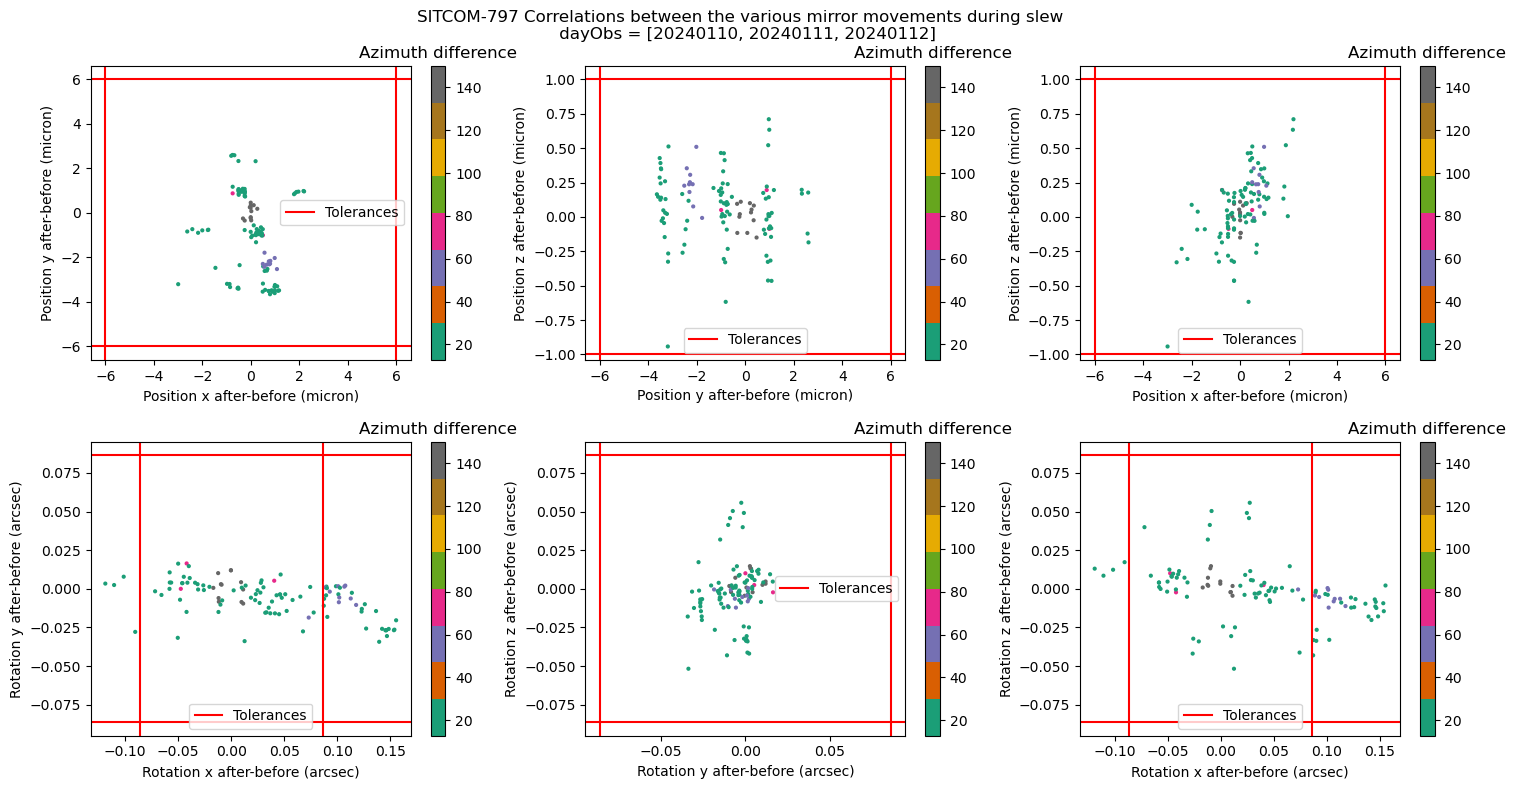

In [165]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

cm = matplotlib.colormaps["Dark2"]

pairs = ["xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 1

title = f"SITCOM-1159 Correlations between the various mirror movements during slew  \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 0.1
)

# Azimuth change
diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    pair = pairs[i]

    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"]) * u.mm.to(
        u.micron
    )
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_1[mask], diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azimuth difference")

    if pair[0] == "x" or pair[0] == "y":
        axs[0][i].axvline(6, color="r", label="Tolerances")
        axs[0][i].axvline(-6, color="r")
    else:
        axs[0][i].axvline(1, color="r", label="Tolerances")
        axs[0][i].axvline(-1, color="r")

    if pair[1] == "x" or pair[1] == "y":
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")
    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")

    axs[0][i].legend()

    # Rotations
    R_diff_1 = (
        results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"]
    ) * u.degree.to(u.arcsec)
    R_diff_2 = (
        results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        R_diff_1[mask], R_diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azimuth difference")

    axs[1][i].axhline(0.0864, color="r", label="Tolerances")
    axs[1][i].axhline(-0.0864, color="r")
    axs[1][i].axvline(0.0864, color="r")
    axs[1][i].axvline(-0.0864, color="r")
    axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## In the following cells we identify some specific individual slews for debugging purpose

In [176]:
# Select slews
pd.set_option("display.max_rows", 1000)
mask = (
    (abs(results["start_azi"] - results["end_azi"]) > 20)
    & (abs(results["start_ele"] - results["end_ele"]) < 0.1)
    & (
        abs(results[f"R_x_after"] - results[f"R_x_before"]) * u.degree.to(u.arcsec)
        > 0.10
    )
)
print(results["i_slew"][mask])

137    183
142    188
211    260
216    265
221    270
265    314
310    361
Name: i_slew, dtype: int64


In [173]:
pd.set_option("display.max_rows", 10)
results

,Unnamed: 0,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,...,R_x_after,R_y_after,R_z_after,start_ele,end_ele,start_azi,end_azi,speed_ele,speed_azi,slew_end
0,0,35,4.067192,-1.465522,5.527362,-1.228425,0.001066,0.007193,0.002080,-0.003157,...,-0.003152,-0.014291,0.008625,82.000000,82.000000,-2.985587e-08,-9.981830,-2.484808e-16,-2.511473,1.705013e+09
1,1,36,6.571246,-1.465810,5.526448,-1.227756,0.000778,0.004677,0.001872,-0.003173,...,-0.003181,-0.014291,0.008628,81.999999,81.999993,-1.000000e+01,9.986955,-2.484808e-16,3.039035,1.705013e+09
2,2,37,6.575204,-1.465878,5.528302,-1.228380,0.000961,0.005385,0.001789,-0.003168,...,-0.003152,-0.014292,0.008626,81.999999,81.999997,1.000000e+01,-9.971949,-2.484808e-16,-3.108955,1.705013e+09
3,3,38,6.574627,-1.465841,5.526488,-1.227719,0.000828,0.004756,0.001953,-0.003173,...,-0.003181,-0.014291,0.008628,81.999999,81.999997,-1.000000e+01,9.983710,-2.484808e-16,3.067862,1.705013e+09
4,4,39,6.618220,-1.465899,5.528216,-1.228411,0.000926,0.005615,0.001823,-0.003168,...,-0.003150,-0.014290,0.008626,81.999999,82.000002,1.000000e+01,-9.976364,-2.484808e-16,-3.096150,1.705013e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,490,3.397379,-1.454450,5.498668,-1.362292,0.011674,0.011762,0.007585,-0.002809,...,-0.002791,-0.014483,0.008625,43.981973,39.450026,-2.706677e-01,-0.680451,-1.302818e+00,-0.110560,1.705105e+09
403,403,491,3.188551,-1.455246,5.511092,-1.369398,0.017485,0.018712,0.006245,-0.002731,...,-0.002762,-0.014467,0.008627,39.437092,42.381402,-8.935691e-01,-1.407721,9.155357e-01,-0.149458,1.705105e+09
404,404,492,3.010277,-1.360454,5.239852,-0.978949,0.789840,2.912527,0.908370,0.001733,...,0.024939,-0.005253,-0.000774,42.366526,40.142541,-1.634362e+00,-4.748823,-7.405081e-01,-1.022449,1.705105e+09
405,405,498,3.421549,-1.449668,5.511158,-1.367491,0.020965,0.029351,0.021830,-0.002686,...,-0.002747,-0.014437,0.008613,41.865930,42.124683,-3.434378e+00,-11.495140,7.601294e-02,-2.345813,1.705106e+09


In [177]:
# Retrieve the some EFD data corresponding to the selected slew
islew = 260

# Define the extra time before and after the slew to display the data
dtt = time.TimeDelta(10, format="sec")
df_incl = getEfdData(
    client,
    "lsst.sal.MTM1M3.inclinometerData",
    begin=slews[islew].begin - dtt,
    end=slews[islew].end + dtt,
)
df_ims = getEfdData(
    client,
    "lsst.sal.MTM1M3.imsData",
    begin=slews[islew].begin - dtt,
    end=slews[islew].end + dtt,
)
df_bal = getEfdData(
    client,
    "lsst.sal.MTM1M3.appliedBalanceForces",
    begin=slews[islew].begin - dtt,
    end=slews[islew].end + dtt,
)
df_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=slews[islew].begin - dtt,
    end=slews[islew].end + dtt,
)

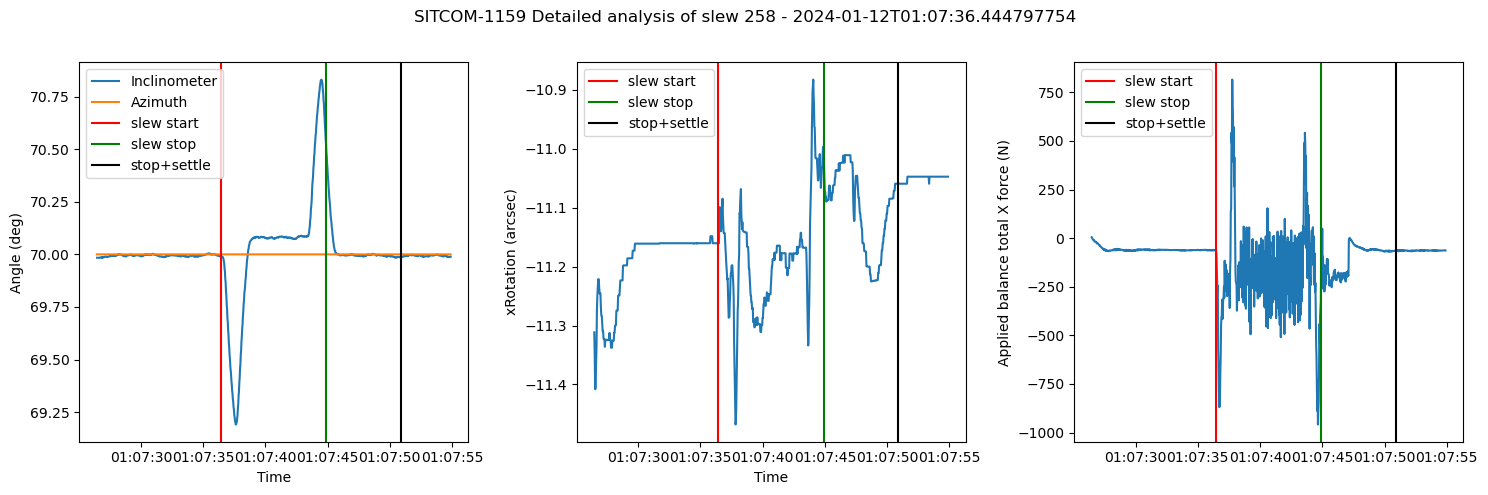

In [184]:
# Plot results
title = f"SITCOM-1159 Detailed analysis of slew {slews[islew].seqNum} - {slews[islew].begin.datetime64}"
fig, axs = plt.subplots(num=title, nrows=1, ncols=3, figsize=(15, 5))
axs[0].plot(df_incl.index, df_incl["inclinometerAngle"], label="Inclinometer")
axs[0].plot(df_ele.index, df_ele["actualPosition"], label="Azimuth")
axs[1].plot(df_ims.index, df_ims["xRotation"] * u.degree.to(u.arcsec))
axs[2].plot(df_bal.index, df_bal["fx"])

axs[0].set_xlabel("Time")
axs[1].set_xlabel("Time")
axs[0].set_ylabel("Angle (deg)")
axs[1].set_ylabel("xRotation (arcsec)")
axs[2].set_ylabel("Applied balance total X force (N)")

axs[0].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[0].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[0].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[1].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[1].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[1].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[2].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[2].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[2].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[0].legend()
axs[1].legend()
axs[2].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

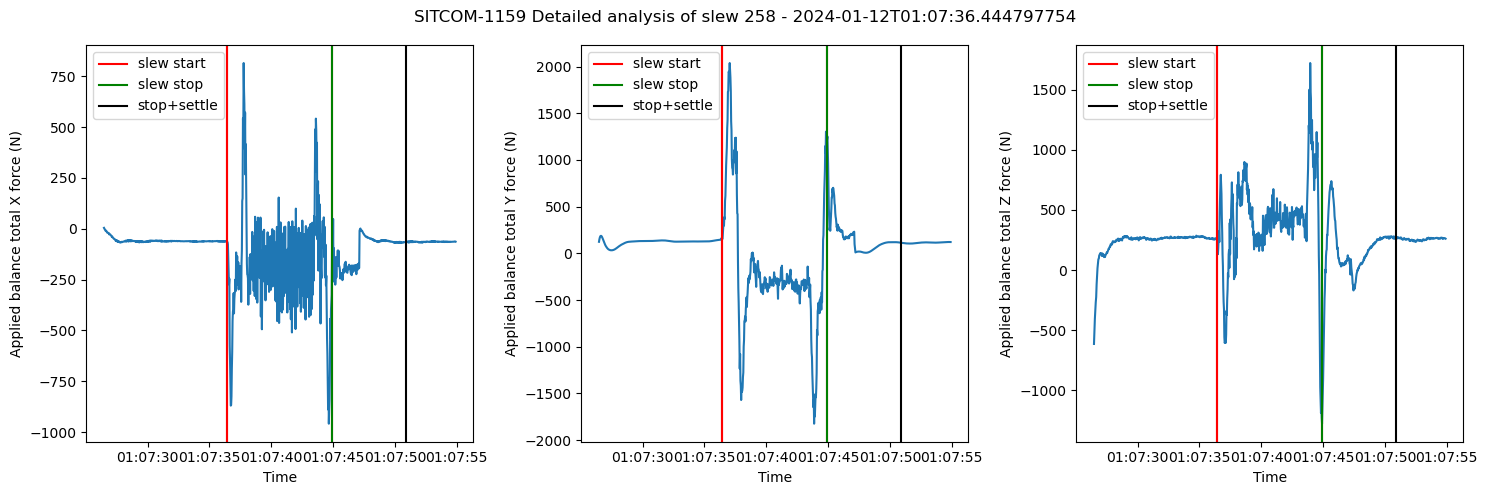

In [186]:
# Plot applied forces in x, y and z
title = f"SITCOM-1159 Detailed analysis of slew {slews[islew].seqNum} - {slews[islew].begin.datetime64}"
fig, axs = plt.subplots(num=title, nrows=1, ncols=3, figsize=(15, 5))
axs[0].plot(df_bal.index, df_bal["fx"])
axs[1].plot(df_bal.index, df_bal["fy"])
axs[2].plot(df_bal.index, df_bal["fz"])
# axs[2].plot(df_bal.index, df_bal["xForces2"])

axs[0].axvline(slews[islew].begin.datetime64, color="r")
axs[0].axvline(slews[islew].end.datetime64, color="r")
axs[1].axvline(slews[islew].begin.datetime64, color="r")
axs[1].axvline(slews[islew].end.datetime64, color="r")
axs[2].axvline(slews[islew].begin.datetime64, color="r")
axs[2].axvline(slews[islew].end.datetime64, color="r")

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Applied balance total X force (N)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Applied balance total Y force (N)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Applied balance total Z force (N)")

axs[0].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[0].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[0].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[1].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[1].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[1].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[2].axvline(slews[islew].begin.datetime64, color="r", label="slew start")
axs[2].axvline(slews[islew].end.datetime64, color="g", label="slew stop")
axs[2].axvline(
    (slews[islew].end + dt_settle).datetime64, color="black", label="stop+settle"
)
axs[0].legend()
axs[1].legend()
axs[2].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusions

We remark that the measurement from the inclinometer varies at the beginning and at the end of the slew probably corresponding to the acceleration and decelaration of the TMA. As the inclinometer values are included in the mirror control loop, an extra force is wrongly applied to counter-balance the effect. 

Experts suggest to fit the applied forces to the inclinometer data in order to be able to subtract the effect of the acceleration from the inclinometer data. This will be done in a separate notebook.